## Run simulation and optimizations for the folded cascode example


In [1]:
import json
import circuits as cir
import optimizers as opt
import ngspice
import pandas as pd
import logging
from datetime import datetime

log_file = 'folded_log.log'
with open(log_file, "w") as f:
    f.write(str(datetime.now().time()))

logging.basicConfig(filename=log_file, level=logging.DEBUG)


In [9]:
#load the cicruit definitions and targets defined in circuit_setup.json
folded_cascode = cir.Circuit("../circuit_examples/folded_cascode_ota/sky130/", corners=None)

#load a sample sizing
with open("../circuit_examples/folded_cascode_ota/sky130/sizing_example.json", 'r') as file:
    sizing = json.load(file)

simulation_result = folded_cascode.simulate(sizing)


print("Folded Cascode SKY 130 TT Simulation Results")

df = pd.DataFrame(simulation_result[0]).transpose()

df['CL'] *= 1e12  
df.rename(columns = {"CL": "CL[pF]"}, inplace=True)  
print(df)


Folded Cascode SKY 130 TT Simulation Results


KeyError: 'CL'

In [3]:
#load the cicruit definitions and targets defined in circuit_setup.json with corners from corners.inc
folded_cascode = cir.Circuit("../circuit_examples/folded_cascode_ota/ptm130/",corners=None)

#load a sample sizing
with open("../circuit_examples/folded_cascode_ota/ptm130/sizing_example.json", 'r') as file:
    sizing = json.load(file)

simulation_result = folded_cascode.simulate(sizing)


print("Simulation Results All Corners")
df = pd.DataFrame(simulation_result[0]).transpose()

# rescale CL to show not 0 in df
df['CL'] *= 1e12
df.rename(columns = {"CL": "CL[pF]"}, inplace=True)  
print(df)

Simulation Results All Corners
    CL[pF]  DELTA_MNM1  DELTA_MNM2  DELTA_MNM3  DELTA_MNM4  DELTA_MNM5  \
TT     6.0    0.585495    0.739938    0.617564    0.619046    0.413995   

    DELTA_MNM6  DELTA_MNM7  DELTA_MNM8  DELTA_MPM0  ...  VOV_MNM5  VOV_MNM6  \
TT    0.639173    0.402403    0.402872    0.472546  ...  0.001432  0.000963   

    VOV_MNM7  VOV_MNM8  VOV_MPM0  VOV_MPM1  VOV_MPM3  VOV_MPM4  VOV_MPM5  \
TT -0.016224 -0.016224   0.37476  0.103984  1.307041  1.307041  0.405695   

    VOV_MPM6  
TT  0.407171  

[1 rows x 42 columns]


In [ ]:
obj,cstr,log = folded_cascode.target.evaluate(simulation_result[0])

print("Objectives")

print( {folded_cascode.objectives[i][0]:(obj[i]*folded_cascode.objectives[i][1]) for i in range(len(obj))})

## Optimizing in Nominal conditions

Outputs are save to the output_folder

This can take a while.


In [8]:
import random
from datetime import datetime
import numpy as np
import pandas as pd
import os



cir.run_optimization()

seed = 42
np.random.seed(seed)
random.seed(seed)
nsga2 = opt.NSGA2()

output_folder = "../run/sky130_folded_cascode/"


if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print("Starting optimization", datetime.now().time(), flush=True)
i = 0
folded_cascode = cir.Circuit("../circuit_examples/folded_cascode_ota/sky130/", corners=None)
for pop, pop_obj,  pop_cstr, pop_data, evals, front_no in nsga2.minimize(
        folded_cascode,pop_size=32, evaluations=32*100, mutation=0.2, crossover=0.6):
        
        print('\r',i, pop_cstr[pop_cstr.argmax()], datetime.now().time(), end='', flush=True)
        with open("{}history32{}_{}.json".format(output_folder,seed, i), "w") as file: 
            json.dump(
            {
                "pop":json.loads(pd.DataFrame(data=pop, columns=folded_cascode.parameters).to_json(orient="records")),
                "obj":json.loads(pd.DataFrame(data=pop_obj, columns=folded_cascode.objectives).to_json(orient="records")),
                "cstr":pop_cstr.tolist(),
                "data":pop_data,
                "evals":evals,
                "fn":[ str(fn) for fn in front_no.tolist()]
            },
            file  
            )
        i = i + 1


Starting optimization 18:06:09.684314
 100 [0.] 18:36:42.922602

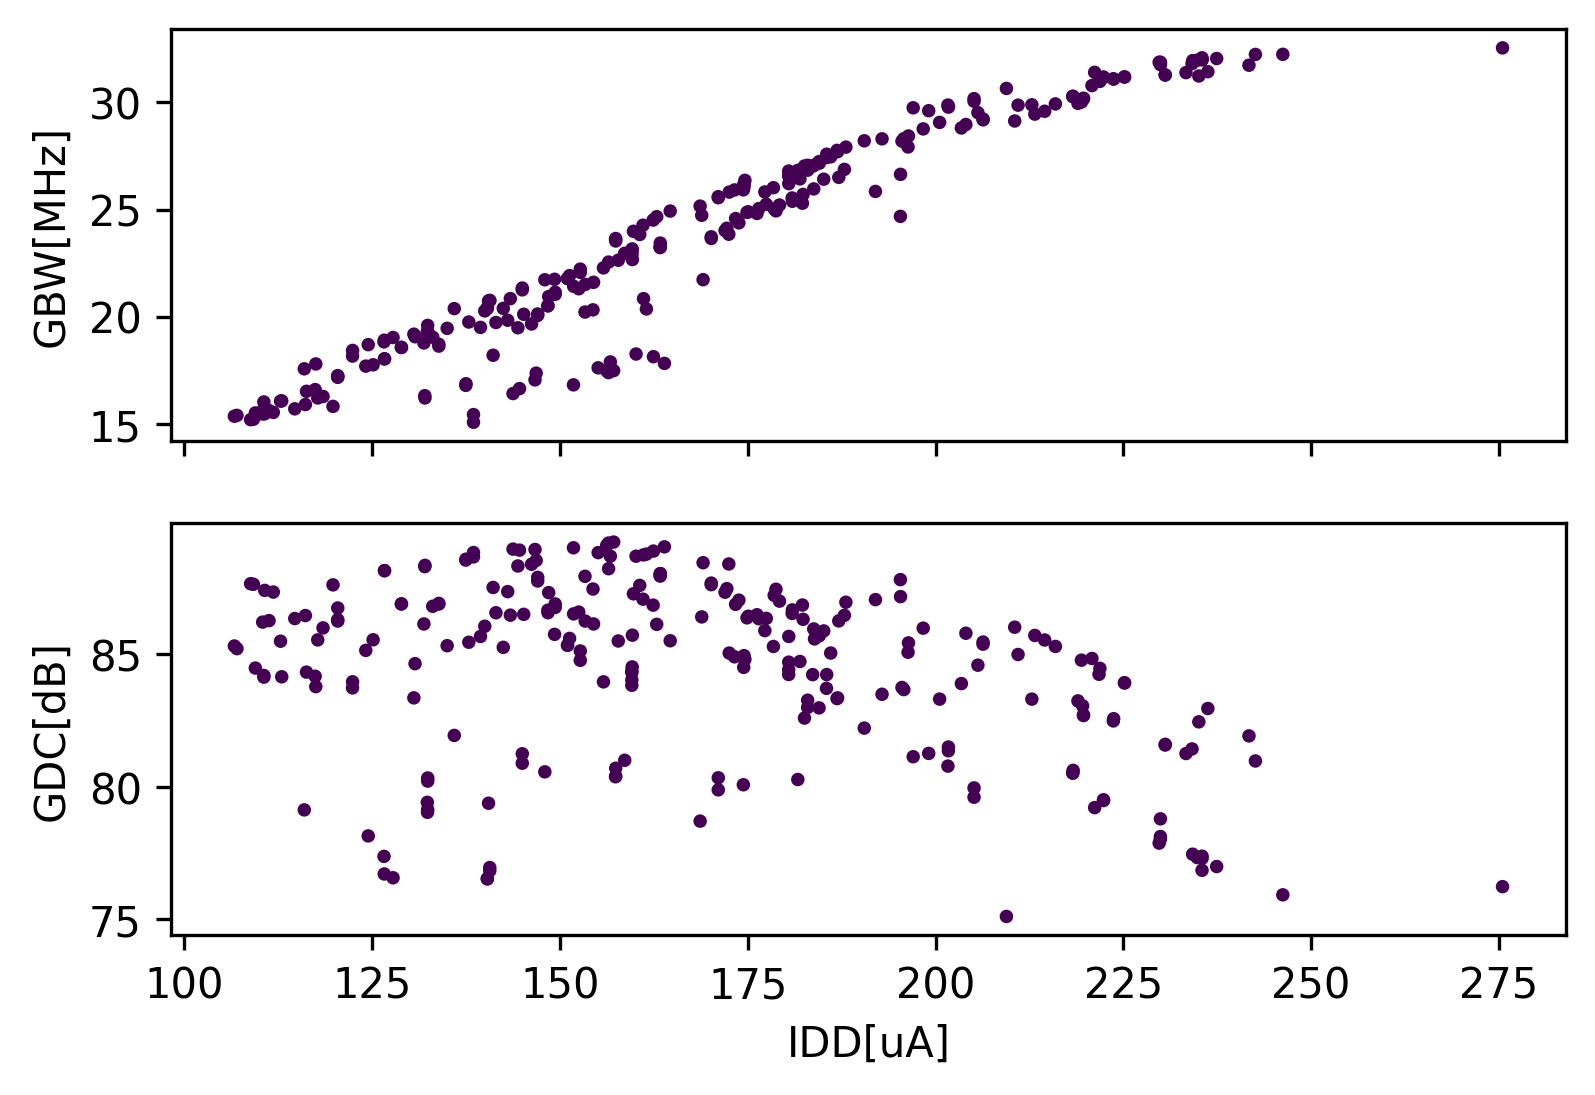

In [1]:
import plot_utils 

seed = 42
output_folder = "../run/sky130_folded_cascode/"

plot_utils.plt_pof(["{}history256{}_{}.json".format(output_folder,seed, 100)], scales = [("[uA]", 1e6),("[MHz]", 1e-6),("[dB]", 1.0)])

